In [1]:
from benji_girgs import generation, plotting, utils
import networkit as nk
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [168]:
n=3000
d=2
tau=2.5
alpha = 1.2

g, edges, weights, pts = generation.generate_GIRG_nk(n, d, tau, alpha)
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)

w_alpha_mean_empirical: 4.694, w_alpha_mean: 5.000


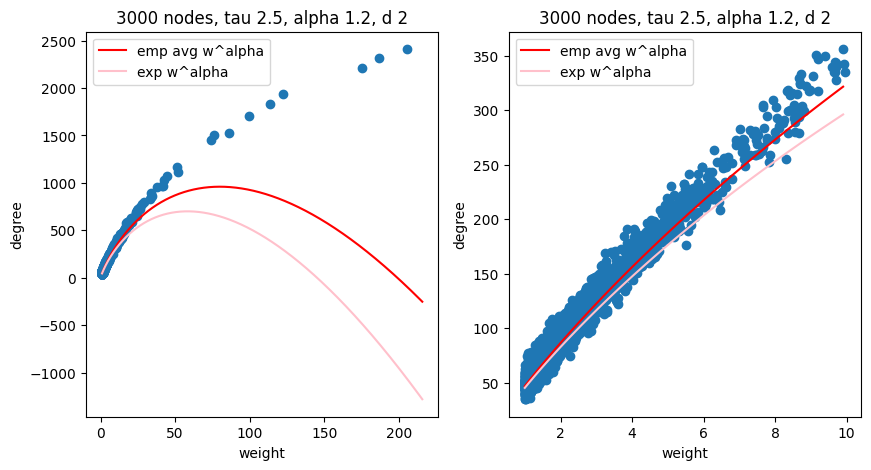

In [169]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
plt.sca(axes[0])

k=max(weights)+10
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

w_mean = (tau-1)/(tau-2)
w_alpha_mean_empirical = np.mean(weights**alpha)
w_alpha_mean = (tau-1)/(tau-1-alpha)

a = w_mean
b = w_mean / (alpha - 1)
c_emp = w_alpha_mean_empirical  * 2**(d*(alpha-1)) * n**(1-alpha) / (1 - alpha)
c = c_emp * w_alpha_mean / w_alpha_mean_empirical

ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.legend()

k=10
plt.sca(axes[1])
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.legend()

print(f'w_alpha_mean_empirical: {w_alpha_mean_empirical:.3f}, w_alpha_mean: {w_alpha_mean:.3f}')

In [55]:
def func(weight):
    expected_degree = (2**d) * ((a + b) * weight + c * weight**alpha)
    return expected_degree

func()

516.7493804173109

In [56]:
import scipy

In [60]:
func2 = lambda w: func(w) - 500
scipy.optimize.fsolve(func2, 100)

array([102.00378808])

In [61]:
func(102.00)

500.03226520184216

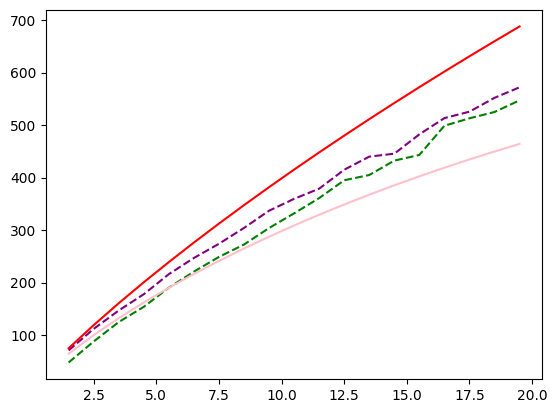

In [11]:
k = 20
npoints = 20
points = np.linspace(1, k, npoints)
midpoints = np.linspace(1, k, 2*(npoints-2) + 3)
midpoints = np.array([midpoints[i] for i in range(len(midpoints)) if i % 2 == 1])
quantiles = []
for i in range(len(points)-1):
    lo, hi = points[i], points[i+1]
    midpoint = midpoints[i]
    quantiles.append(np.quantile(degrees[(lo < weights) & (weights < hi)], [0.2, 0.8]))
quantiles = np.array(quantiles)

plt.plot(midpoints, quantiles[:, 0], color='green', label='0.2 quantile', linestyle='--')
plt.plot(midpoints, quantiles[:, 1], color='purple', label='0.8 quantile', linestyle='--')

ys_emp = (2**d) * ((a + b) * midpoints + c_emp * midpoints**alpha)
ys = (2**d) * ((a + b) * midpoints + c * midpoints**alpha)

plt.plot(midpoints, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(midpoints, ys, color='pink', label='exp w^alpha')

In [12]:
from girg_sampling import girgs

In [13]:
def cgirg_gen(n, d, tau, alpha, desiredAvgDegree=None):
    """Generate a GIRG with C-library"""
    weights = girgs.generateWeights(n, tau)
    scaled_weights = weights
    const = 1
    if desiredAvgDegree is not None:
        const = girgs.scaleWeights(weights, desiredAvgDegree, d, alpha)
        scaled_weights = list(np.array(weights) * const)
    pts = girgs.generatePositions(n, d)
    edges = girgs.generateEdges(scaled_weights, pts, alpha)
    # Make graph from edge list (not adjacency matrix)
    gnx = nx.from_edgelist(edges)
    missing_nodes = set(list(range(n)))
    for node in gnx.nodes:
        missing_nodes.remove(node)
    
    for missing_node in missing_nodes:
        gnx.add_node(missing_node)

    gnk = nk.nxadapter.nx2nk(gnx)
    id2gnk = dict((gnx_id, gnk_id) for (gnx_id, gnk_id) in zip(gnx.nodes(), range(gnx.number_of_nodes())))

    return gnk, edges, weights, pts, const, id2gnk

In [170]:
g, edges, weights, pts, const, id2gnk = cgirg_gen(n, d, tau, alpha, 30.0)
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
degrees2 = [g.degree(v) for v in range(g.numberOfNodes())]
gnk2id = {v: k for k, v in id2gnk.items()}
weights = np.array([weights[gnk2id[i]] for i in range(len(weights))])

func = expected_node_weight_func_c(n, tau, alpha, d, const)

In [171]:
const

0.7092098863638593

w_alpha_mean_empirical: 4.637, w_alpha_mean: 5.000


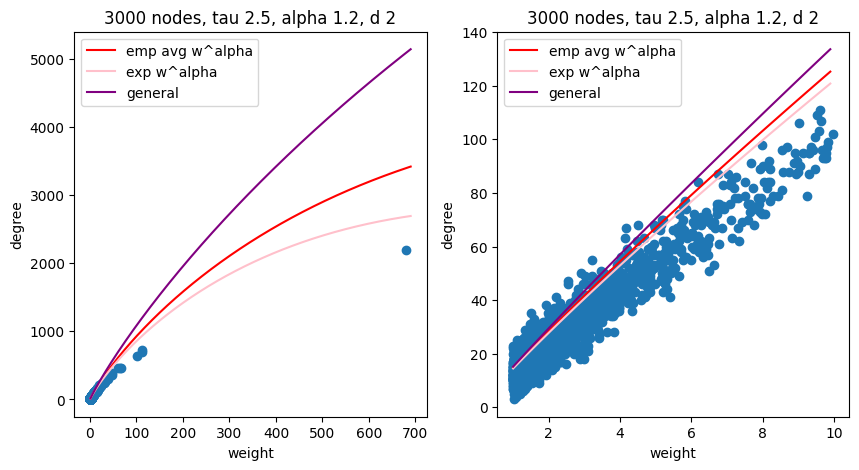

In [172]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
plt.sca(axes[0])

k=max(weights)+10
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

w_mean = (tau-1)/(tau-2)
# w_mean = np.mean(weights)
w_alpha_mean_empirical = np.mean(weights**alpha)
w_alpha_mean = (tau-1)/(tau-1-alpha)

# const = 1


a = (n/np.sum(weights)) * w_mean * const**(1/alpha)
b = (n/np.sum(weights)) * w_mean * const**(1/alpha) / (alpha - 1)
c_emp = (n/(np.sum(weights)**(alpha))) *  w_alpha_mean_empirical  * const / (1 - alpha)
c = c_emp * w_alpha_mean / w_alpha_mean_empirical


ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
ys2 = func(xs)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.plot(xs, ys2, color='purple', label='general')
plt.legend()

k=10
plt.sca(axes[1])
plt.scatter(weights[weights < k], degrees[weights < k])
plt.xlabel('weight')
plt.ylabel('degree')
plt.title(f'{n} nodes, tau {tau}, alpha {alpha}, d {d}')
xs = np.arange(1.0, k, 0.1)

ys_emp = (2**d) * ((a + b) * xs + c_emp * xs**alpha)
ys = (2**d) * ((a + b) * xs + c * xs**alpha)
ys2 = func(xs)
plt.plot(xs, ys_emp, color='r', label='emp avg w^alpha')
plt.plot(xs, ys, color='pink', label='exp w^alpha')
plt.plot(xs, ys2, color='purple', label='general')
plt.legend()

print(f'w_alpha_mean_empirical: {w_alpha_mean_empirical:.3f}, w_alpha_mean: {w_alpha_mean:.3f}')

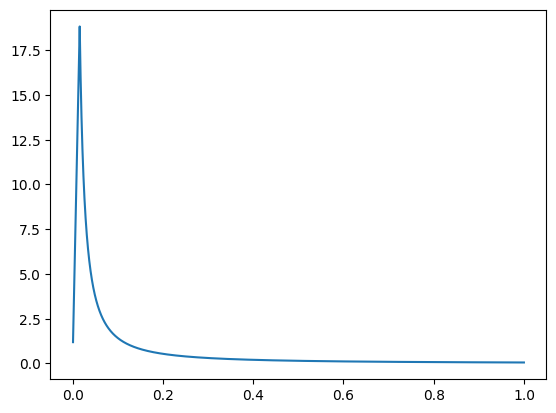

In [173]:
rs = np.arange(0.001, 1, 0.0001)
temp = p_r_given_wu_wv(n, tau, alpha, d, const, 1.5, 2.0)
ps = temp(rs)
plt.plot(rs, ps)

In [135]:
w_u = 3.0
w_v = 4.0

w_mean = (tau-1)/(tau-2)
# W ~ n w_mean
p_uv_given_r = lambda r: \
    np.minimum(1, const * (
           (w_u * w_v / (rs**d * n*w_mean))
       )**alpha)


p_r = lambda r: 2**d * d * r**(d-1) / n


a =  const**(1/alpha)
b =  const**(1/alpha) / (alpha - 1)

w_mean = (tau-1)/(tau-2)
E_W = n * w_mean

w_alpha_mean = (tau-1)/(tau-1-alpha)
# E[W^alpha] ~= n * E[w^alpha]
E_W_alpha = n * w_alpha_mean
p_uv = (2**d) * (
    (a + b) * w_u * w_v / E_W
     + const * (w_u * w_v)**alpha / E_W_alpha
)

In [127]:
p_uv
p_r(0.4)

0.0010666666666666667

In [128]:
def p_r_given_wu_wv(n, tau, alpha, d, const, w_u, w_v,):
    w_mean = (tau-1)/(tau-2)
    # W ~ n w_mean
    p_uv_given_r = lambda r: \
        np.minimum(1, const * (
               (w_u * w_v / (rs**d * n*w_mean))
           )**alpha)


    p_r = lambda r: 2**d * d * r**(d-1)


    a =  const**(1/alpha)
    b =  const**(1/alpha) / (alpha - 1)

    w_mean = (tau-1)/(tau-2)
    E_W = n * w_mean

    w_alpha_mean = (tau-1)/(tau-1-alpha)
    # E[W^alpha] ~= n * E[w^alpha]
    E_W_alpha = n * w_alpha_mean
    p_uv = (2**d) * (
        (a + b) * w_u * w_v / E_W
         + const * (w_u * w_v)**alpha / E_W_alpha
    )

    return lambda r: p_r(r) * p_uv_given_r(r) / p_uv

def expected_node_weight_func_c(n, tau, alpha, d, const):
    w_mean = (tau-1)/(tau-2)
    # w_mean = np.mean(weights)
    # w_alpha_mean_empirical = np.mean(weights**alpha)
    w_alpha_mean = (tau-1)/(tau-1-alpha)

    # const = 1

    # W ~= n w_mean => Sum_v n w_v/W ~= 1
    a =  const**(1/alpha)
    b =  const**(1/alpha) / (alpha - 1)
    # c_emp = (n/(np.sum(weights)**(alpha))) *  w_alpha_mean_empirical  * const / (1 - alpha)
    # W^alpha ~= n w_alpha_mean => Sum_v n w_v^alpha W^{-alpha} approxeq n**(1-alpha)
    c = n**(1-alpha) * const / (1-alpha)

    def func(weight):
        expected_degree = (2**d) * ((a + b) * weight + c * weight**alpha)
        return expected_degree
    
    return func

In [174]:
from scipy.integrate import quad, dblquad, tplquad
w_u, w_a, w_b = 2.5, 1.5, 2.0
w_mean = (tau-1)/(tau-2)
p_ra = p_r_given_wu_wv(n, tau, alpha, d, const, w_u, w_a)
p_rb = p_r_given_wu_wv(n, tau, alpha, d, const, w_u, w_b)

def dot_to_dist(ra, rb, dot):
    return np.sqrt(ra**2 + rb**2 - 2*dot)

# dblquad(lambda ra, rb: quad(lambda p_ra(ra) * p_rb(rb) * min(1, const * (w_a * w_b)))

In [ ]:
r_a = 0.01
r_b = 0.015

quad(lambda r: scipy.stats.beta.pdf((dot+1)/2) * min(1, const * (w_a * w_b/(n * w_mean * r**d))**alpha) * , -

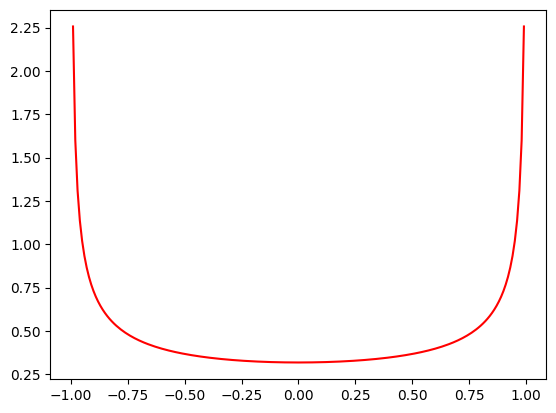

In [177]:
xs = np.arange(-1.0, 1.0, 0.01)
pdf = 0.5* scipy.stats.beta.pdf((xs+1)/2, (d-1)/2, (d-1)/2)
plt.plot(xs, pdf, color='red')

In [176]:
d

2

In [ ]:
scipy.stats.beta.pdf((xs+1)/2, (d-1)/2, (d-1)/2)

In [149]:
d = 100
rx = 1
ry = 1
outs = []
for _ in range(1000):
    x = np.random.normal(size=(d,))
    x = x/np.linalg.norm(x) * rx
    y = np.random.normal(size=(d,))
    y = y/np.linalg.norm(y) * ry
#     outs.append(np.arccos(x@y/(rx*ry)))
#     outs.append((0.5*(-np.linalg.norm(y-x)**2 + rx**2 + ry**2), x @ y))
    outs.append(x @ y)

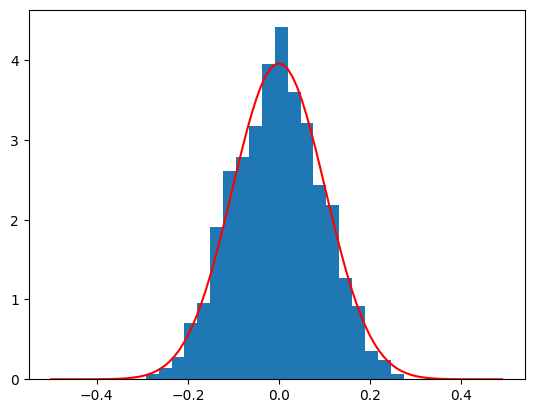

In [162]:
plt.hist(outs, bins=20, density=True)
xs = np.arange(-0.5, 0.5, 0.01)
pdf = 0.5* scipy.stats.beta.pdf((xs+1)/2, (d-1)/2, (d-1)/2)
plt.plot(xs, pdf, color='red')
# plt.axvline(np.pi/2, color='r')

In [163]:
from scipy.integrate import quad, dblquad
w_u, w_a, w_b = 2.5, 1.5, 2.0
p_r_given_wu_wv(n, tau, alpha, d, const, w_u, w_v,)

In [164]:
w_u, w_a, w_b = 2.5, 1.5, 2.0

In [ ]:
p_r_given_wu_wv(n, tau, alpha, d, const, w_u, w_v,)

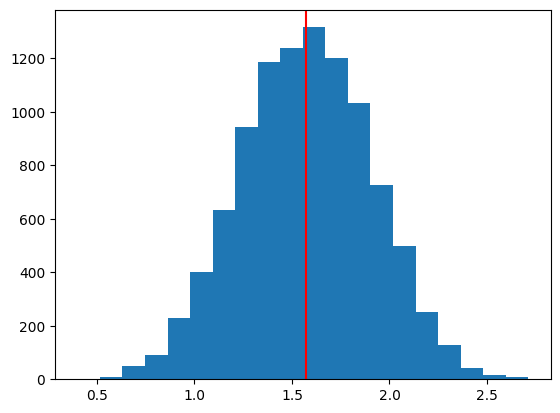

In [45]:
plt.hist(outs, bins=20)
plt.axvline(np.pi/2, color='r')

In [27]:
a, b, c_emp

(1.0042439025062944, 5.021219512531473, -1.2367300747224501)

In [62]:
n = 10000000

w_mean = (tau-1)/(tau-2)
w_alpha_mean = np.mean(weights**alpha)
w_alpha_mean2 = (tau-1)/(tau-1-alpha)
a = w_mean
b = w_mean / (alpha - 1)
c = w_alpha_mean  * 2**(d*(alpha-1)) * n**(1-alpha) / (1 - alpha)
c2 = c * w_alpha_mean2 / w_alpha_mean
print(f'{a:.3f} {b:.3f} {c:.3f} {c2:.3f}')

3.000 15.000 -0.265 -0.330


In [63]:
1-alpha

-0.19999999999999996

In [64]:
10000000000 **(-0.2)

0.009999999999999997

In [65]:
w_mean
w_alpha_mean

3.0

4.023787663617149

In [14]:
n=1000
d=2
tau=2.5
alphas = np.arange(1.1, 10.0, 0.4)
outs = []

for alpha in tqdm(alphas):
    for _ in range(3):
        g, edges, weights, pts = generation.cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
        percs = utils.get_perc_lower_common_nhbs(g, 2000)
        outs.append((alpha, np.median(percs)))


# plt.scatter([out[0] for out in outs], [out[1] for out in outs])

100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Text(0.5, 0, 'alpha')

Text(0, 0.5, 'median % common neighbours')

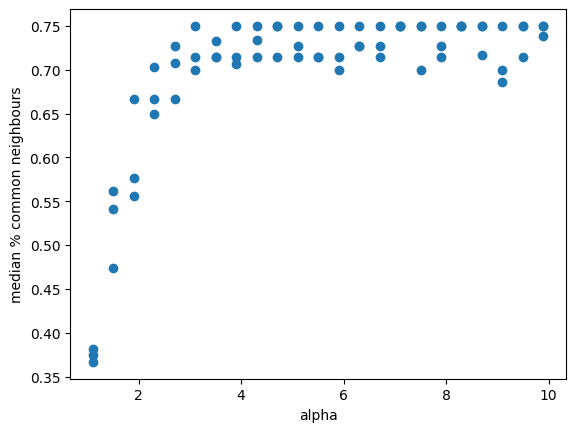

In [15]:
plt.scatter([out[0] for out in outs], [out[1] for out in outs])
plt.xlabel('alpha')
plt.ylabel('median % common neighbours')

In [20]:
percs

[0.6363636363636364,
 0.6,
 0.6666666666666666,
 0.8888888888888888,
 0.6666666666666666,
 0.75,
 0.8333333333333334,
 0.8,
 0.5384615384615384,
 0.8461538461538461,
 0.7142857142857143,
 0.75,
 0.6666666666666666,
 0.8888888888888888,
 0.6,
 0.8571428571428571,
 0.7692307692307693,
 0.75,
 0.18181818181818182,
 0.4642857142857143,
 0.8333333333333334,
 0.7692307692307693,
 0.6875,
 0.8571428571428571,
 0.6666666666666666,
 0.9655172413793104,
 0.5714285714285714,
 0.5555555555555556,
 0.8888888888888888,
 0.75,
 0.5,
 0.8,
 0.75,
 0.5,
 0.75,
 0.3584905660377358,
 0.8,
 0.8888888888888888,
 0.9166666666666666,
 0.7142857142857143,
 0.631578947368421,
 0.5454545454545454,
 0.75,
 0.75,
 0.8,
 0.45454545454545453,
 0.75,
 0.9523809523809523,
 0.5,
 0.42105263157894735,
 0.46153846153846156,
 0.34375,
 0.5555555555555556,
 0.6666666666666666,
 0.6,
 0.8,
 0.2682926829268293,
 0.75,
 0.8648648648648649,
 0.8,
 0.5,
 0.875,
 0.6,
 0.7142857142857143,
 0.9523809523809523,
 0.322580645161290

In [13]:
g, edges, weights, pts = generation.cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
nk.overview(g)

Network Properties:
nodes, edges			1000, 5526
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.011063
clustering coefficient		0.692514
min/max/avg degree		1, 210, 11.052000
degree assortativity		0.219826
number of connected components	1
size of largest component	1000 (100.00 %)


In [21]:
edges = list(g.iterEdges())

In [23]:
edges[0:10]

[(0, 1),
 (0, 270),
 (0, 133),
 (0, 388),
 (0, 135),
 (0, 132),
 (0, 251),
 (0, 65),
 (0, 129),
 (0, 235)]

In [24]:
dijkstra = nk.distance.Dijkstra(g, 0, True, True, 1)
dijkstra.run()

In [27]:
dijkstra.distance(1)
dijkstra.distance(2)

1.0

2.0

In [34]:
dijkstra.getPath(2)

[0, 133, 2]

In [35]:
g.removeEdge(0, 1)

In [44]:
biBFS = nk.distance.BidirectionalBFS(g, 0, 1, True)

In [46]:
biBFS.run()

In [38]:
biBFS.getPath()

[65]

In [40]:
biBFS.getDistance()

2.0

In [50]:
source, target = edges[1000]
source, target

(56, 456)

In [51]:
g.removeEdge(source, target)
biBFS = nk.distance.BidirectionalBFS(g, source, target, True)
biBFS.run()

In [52]:
biBFS.getPath()

[659]

In [55]:
preds = biBFS.getPredecessors()

In [64]:
preds = np.array(preds)


In [65]:
np.sum(preds==0)

979

In [68]:
np.unique(preds)

array([  0,  56, 659])

In [70]:
np.argwhere(preds==56).reshape(-1)

array([  1,  55,  56, 132, 134, 135, 161, 163, 165, 250, 277, 455, 653,
       659, 660, 661, 662, 718])

In [6]:
n=1000
d=2
tau=2.5
alpha=2.0
from girg_sampling import girgs

def cgirg_gen(n, d, tau, alpha, desireAvgDegree=None):
    """Generate a GIRG with C-library"""
    weights = girgs.generateWeights(n, tau)
    if desireAvgDegree is not None:
        weights = list(np.array(weights) * girgs.scaleWeights(weights, desireAvgDegree, d, alpha))
    pts = girgs.generatePositions(n, d)
    edges = girgs.generateEdges(weights, pts, alpha)
    # Make graph from edge list (not adjacency matrix)
    gnx = nx.from_edgelist(edges)
    gnk = nk.nxadapter.nx2nk(gnx)
    id2gnk = dict((gnx_id, gnk_id) for (gnx_id, gnk_id) in zip(gnx.nodes(), range(gnx.number_of_nodes())))

    return gnk, edges, weights, pts, id2gnk


In [34]:
n=5000
d=2
tau=2.5
alpha=1.01


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
    #     print(int(biBFS.getDistance())
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([38801,  1199]))

(array([1, 2]), array([39561,   439]))

(array([1, 2]), array([38212,  1788]))

In [33]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
    #     print(int(biBFS.getDistance())
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2, 3]), array([39212,   787,     1]))

(array([0, 1, 2]), array([    2, 39001,   997]))

(array([1, 2]), array([39356,   644]))

In [35]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    edges = list(g.iterEdges())
    outs = []
    for _ in range(40000):
        s, t = edges[np.random.choice(len(edges))]
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([39593,   407]))

(array([1, 2, 3]), array([39272,   727,     1]))

(array([1, 2, 3]), array([38939,  1058,     3]))

In [52]:
n=5000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
    edges = list(g.iterEdges())
    outs = []
    low, up = np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)
    for _ in range(40000 * 12):
        s, t = edges[np.random.choice(len(edges))]
        degs = [degrees[s], degrees[t]]
        degs.sort()
        if degs[0] > low or degs[1] < up:
            continue
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2]), array([39972,   974]))

(array([1, 2]), array([41594,  1349]))

(array([1, 2]), array([41166,  1803]))

In [78]:
n=40000
d=2
tau=2.5
alpha=1.5


for _ in range(3):
    g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)
    degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
    edges = list(g.iterEdges())
    outs = []
    low, up = np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)
    for _ in range(40000 * 12):
        s, t = edges[np.random.choice(len(edges))]
        degs = [degrees[s], degrees[t]]
        degs.sort()
        if degs[0] > low or degs[1] < up:
            continue
        _ = g.removeEdge(s, t)
        biBFS = nk.distance.BidirectionalBFS(g, s, t, True)
        _ = biBFS.run()
        _ = g.addEdge(s, t)
        outs.append((s, biBFS.getPath(), t))

    lengths = [len(x[1]) for x in outs]
    np.unique(lengths, return_counts=True)


(array([1, 2, 3]), array([40016,  1205,     2]))

(array([1, 2]), array([39622,  1085]))

(array([1, 2, 3]), array([36288,  1776,    11]))

In [90]:
n=10000
d=3
tau=2.4
alpha=1.5

g, edges, weights, pts, id2gnk = cgirg_gen(n=n, d=d, tau=tau, alpha=alpha)

outs = []
for _ in range(10):
    v = np.random.choice(g.numberOfNodes())
    bfs = nk.distance.BFS(g, source=v, storePaths=True, storeNodesSortedByDistance=True)
    bfs.run()
    dists = bfs.getDistances()
    outs.append(np.unique(dists, return_counts=True)[1])

In [91]:
outs

[array([   1,   21, 7658, 2320]),
 array([   1,  126, 9228,  645]),
 array([   1,   77, 8575, 1347]),
 array([   1,   24, 4237, 5738]),
 array([   1,   33, 2861, 7105]),
 array([   1,   35, 5402, 4562]),
 array([   1,   72, 8743, 1184]),
 array([   1,   27, 8062, 1910]),
 array([   1,   91, 9087,  821]),
 array([   1,   23, 7761, 2215])]

In [92]:
g.degree(v)

23

In [93]:
gnk2id = {v:k for k, v in id2gnk.items()}

In [97]:
w = weights[gnk2id[v]]
w
r = w**(1/d)
r
r**d

1.2376200838672948

1.0736493103334088

1.2376200838672948

In [98]:
degrees2 = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
degrees = [0]*len(degrees2)
for i, x in enumerate(degrees2):
    degrees[gnk2id[i]] = x


Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '10000 nodes, tau 2.4, alpha 1.5, d 3')

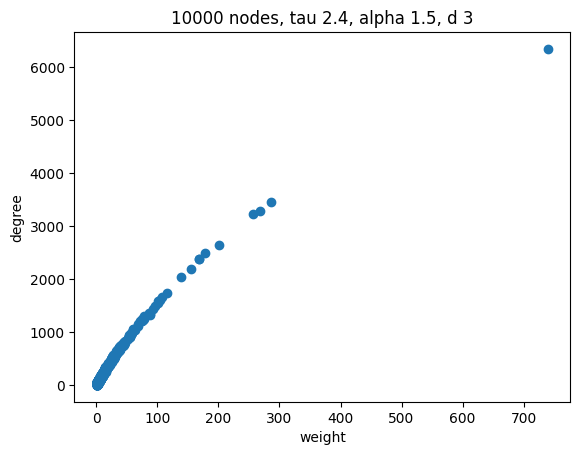

In [100]:
plt.scatter(weights, degrees)
plt.xlabel('weight')
plt.ylabel('degree')
plt.title('10000 nodes, tau 2.4, alpha 1.5, d 3')

Text(0.5, 0, 'weight')

Text(0, 0.5, 'degree')

Text(0.5, 1.0, '10000 nodes, tau 2.4, alpha 1.5, d 3')

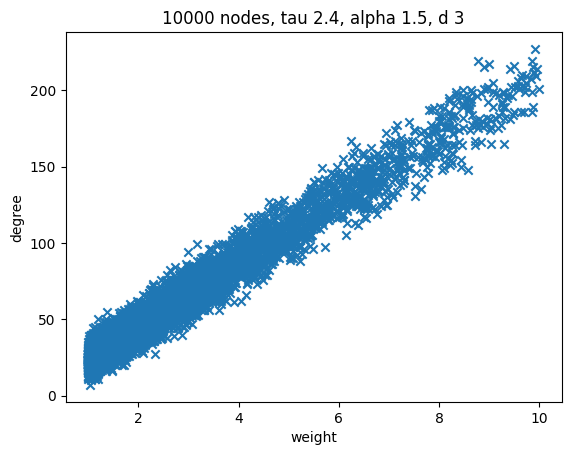

In [103]:
weights, degrees = np.array(weights), np.array(degrees)
plt.scatter(weights[weights < 10], degrees[weights < 10], marker='x')
plt.xlabel('weight')
plt.ylabel('degree')
plt.title('10000 nodes, tau 2.4, alpha 1.5, d 3')

In [41]:
np.quantile(weights, q=[0.25, 0.5, 0.75])

array([1.21491151, 1.59952941, 2.56272572])

In [48]:
degrees = np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)
np.quantile(degrees, q=[0.2, 0.8]).astype(np.int64)

array([13, 34])

In [45]:
np.array(nk.centrality.DegreeCentrality(g).run().scores()).astype(np.int64)

array([ 106, 1566, 1247, ...,   10,    8,   12])

In [49]:
a = [1, 2, 3, 5, -1]
a.sort()
a

[-1, 1, 2, 3, 5]

In [93]:
edges[:5]

[(985, 726), (9, 726), (412, 726), (872, 726), (781, 726)]

In [94]:
g.hasEdge(985, 726)

False

In [95]:
edges2 = list(g.iterEdges())

In [96]:
edges2[:5]

[(0, 1), (0, 281), (0, 282), (0, 152), (0, 221)]

In [97]:
(0, 1) in edges

False

In [89]:
stuff = []
for _ in edges:
    stuff = stuff + list(_)

In [91]:
min(stuff)
max(stuff)

0

999